# Решение для соревнования [SF-DST] Booking reviews

### Постановка задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

**Условия соревнования:**
* Данное соревнование является бессрочным и доступно для всех потоков.

* Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

* Тестовая выборка представлена в LeaderBoard целиком.

* Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

**Дополнительно**

Обратите внимание, что к данному соревнованию создано базовое решение:

### Метрика качества 
Результаты оцениваются по метрике MAPE ## Файл представления Для каждого **id** отеля в наборе тестовых данных вы должны предсказать рейтинг отеля для **reviewer_score** переменной. Файл должен содержать заголовок и иметь следующий формат: 

``` reviewer_score,id 1,1 ```

### Файлы для соревнования
* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате

**Признаки**

* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

### Содержание работы
<a id='0'></a>
* <a href ="#1"> 1. Импорт библиотек и подгрузка данных.</a>
* <a href ="#2"> 2. Очистка данных.</a>
* <a href ="#3"> 3. Исследование данных.</a>
* <a href ="#4"> 4. Генерация признаков.</a>
* <a href ="#5"> 5. Преобразование признаков.</a>
* <a href ="#6"> 6. Отбор признаков.</a>
* <a href ="#7"> 7. Обучение модели.</a>


<a id='1'></a>


## 1. Импорт библиотек и подгрузка данных

<a href ="#0"> Вверх</a>

In [617]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [618]:
import sys
sys.path.insert(1, '../../my_libs/')

from get_data import data_hotels

In [619]:
# Подгрузим наши данные из соревнования

DATA_DIR = data_hotels['folder_link']
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [620]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [621]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [622]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [623]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [624]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [625]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [626]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


<a id='2'></a>

## 2. Очистка данных

<a href ="#0"> Вверх</a>

In [627]:
print('В датасете {} дубликатов в тренировочной выборке'.format(df_train[df_train.duplicated()].shape[0]))
df_train.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов составляет: {}'.format(df_train.shape[0]))

В датасете 307 дубликатов в тренировочной выборке
Количество строк после удаления дубликатов составляет: 386496


In [628]:
print('В датасете {} дубликатов в тестовой выборке'.format(df_test[df_test.duplicated()].shape[0]))

В датасете 29 дубликатов в тестовой выборке


In [629]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], ignore_index = True) # объединяем

In [630]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [631]:
data[(data.lng.isna()) | (data.lat.isna())].shape[0] 

3268

In [632]:
# посмотрим есть ли взаимосвязь между пропусками и отелями:

hotel_adress = data[(data.lng.isna()) & (data.lat.isna())].groupby(by = ['hotel_address','hotel_name']).count().iloc[:,0].reset_index()
hotel_adress

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55
2,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290
3,Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146
4,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,93
5,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Hotel Park Villa,61
6,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,Fleming s Selection Hotel Wien City,658
7,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,Cordial Theaterhotel Wien,57
8,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,Hotel Daniel Vienna,245
9,Paragonstra e 1 11 Simmering 1110 Vienna Austria,Roomz Vienna,49


In [633]:
# не получилось через google.maps api получить доступ, а т.к pаписей немного, нашел из вручную
geo_list = [48.83557774540167, 2.325449615375374], [48.88890917133979, 2.333131539489445],\
    [48.90646271737047, 2.286031792843036], [41.39161236219267, 2.177872539178857], [48.220880464073225, 16.366568581790354],\
    [48.23777955164721, 16.30049133008413], [48.2093946214496, 16.353391952955008], [48.209534571684244, 16.351474025963768],\
    [48.18885768730692, 16.383779297128065], [48.22291469050906, 16.393282694151672], [41.39267682257886, 2.1673975968485046],\
    [48.21960511317031, 16.28563501246867], [41.38479586582278, 2.1609370896181153], [48.24593013949892, 16.341821608782634],\
    [48.21368706024632, 16.379908197129218], [48.21681386879807, 16.359905697129335], [48.220438964319705, 16.355786410625193]

# геоданные в такой де последовательности, сделаем словарь
adres_geo_dict = {}

for a, h in zip(geo_list, list(hotel_adress['hotel_address'])):
    adres_geo_dict[h] = a

In [634]:
# не уверен, что это будет значимый признак (не указаны геоданные), но на всякий случай его сделаю, в случае ненадобности - удалю, до того, ка заполню пропуски 
# определять буду по lat т.к. пропуски идентичны
data['lat_lng'] = (data.lng.isna()) & (data.lat.isna())

In [635]:
def get_geo(address, adres_geo_dict):
  if address in list(adres_geo_dict.keys()):
    return pd.Series([adres_geo_dict[address][0], adres_geo_dict[address][1]], index = ['lat','lng'])

In [636]:
data.loc[data[(data.lat.isna() | data.lng.isna())].index, ['lat','lng']] = data[data.lat.isna() | data.lng.isna()].loc[:].apply(lambda x: get_geo(x.hotel_address, adres_geo_dict), axis = 1)

<style>
  p {
  font-family: Verdana, Arial, Helvetica, sans-serif; 
  font-size: 13pt; /* Размер шрифта в пунктах */ 
  }
</style>
<span style="color:green"><b>Вывод:</b></span> <br>
Мы проверили данные на наличие пропусков и дубликатов, пропуски были в геоданных, т.к. их немного нашел их на гугл-картах. Что касается дубликатов, то удалили их только в тренировочной выборке, т.к. тестовую выборку трогать:
1. нет смысла, там будет предсказан показатель
2. не стот удалять, т.к. выборка будет отправлена на проверку и можно сбить порядок в sample_submission
Также появился новый признак 'lat_lng' который указывает на то били ли пропущенны значения в геоданных

<a id='3'></a>


## 3. Исследование данных

<a href ="#0"> Вверх</a>

In [637]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [638]:
data.describe(include = 'all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample,lat_lng
count,515431,515431.000000,515431,515431.000000,515431,515431,515431,515431.000000,515431.000000,515431,515431.000000,515431.000000,515431.000000,515431,515431,515431.000000,515431.000000,515431.00000,515431
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,NaN,55242,731,NaN,NaN,NaN,2
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN,False
freq,4789,NaN,2584,NaN,4789,245165,127816,NaN,NaN,35924,NaN,NaN,NaN,5101,2584,NaN,NaN,NaN,512163
mean,NaN,498.275079,NaN,8.397630,NaN,NaN,NaN,18.539760,2744.259084,NaN,17.777342,7.165215,6.296715,NaN,NaN,49.432766,2.893744,0.74985,NaN
std,NaN,500.618961,NaN,0.548033,NaN,NaN,NaN,29.690973,2317.823718,NaN,21.803204,11.038742,3.902967,NaN,NaN,3.461228,4.668776,0.43310,NaN
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,0.000000,NaN,NaN,41.328376,-0.369758,0.00000,NaN
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,0.000000,NaN,NaN,48.214066,-0.143372,0.00000,NaN
50%,NaN,342.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,7.900000,NaN,NaN,51.499981,0.019886,1.00000,NaN
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3633.000000,NaN,22.000000,8.000000,9.600000,NaN,NaN,51.516288,4.841163,1.00000,NaN


In [639]:
num_columns = [s for s in data.columns if data[s].dtypes != 'object']
len(num_columns)

11

In [640]:
sns.set (font_scale= 0.7 )

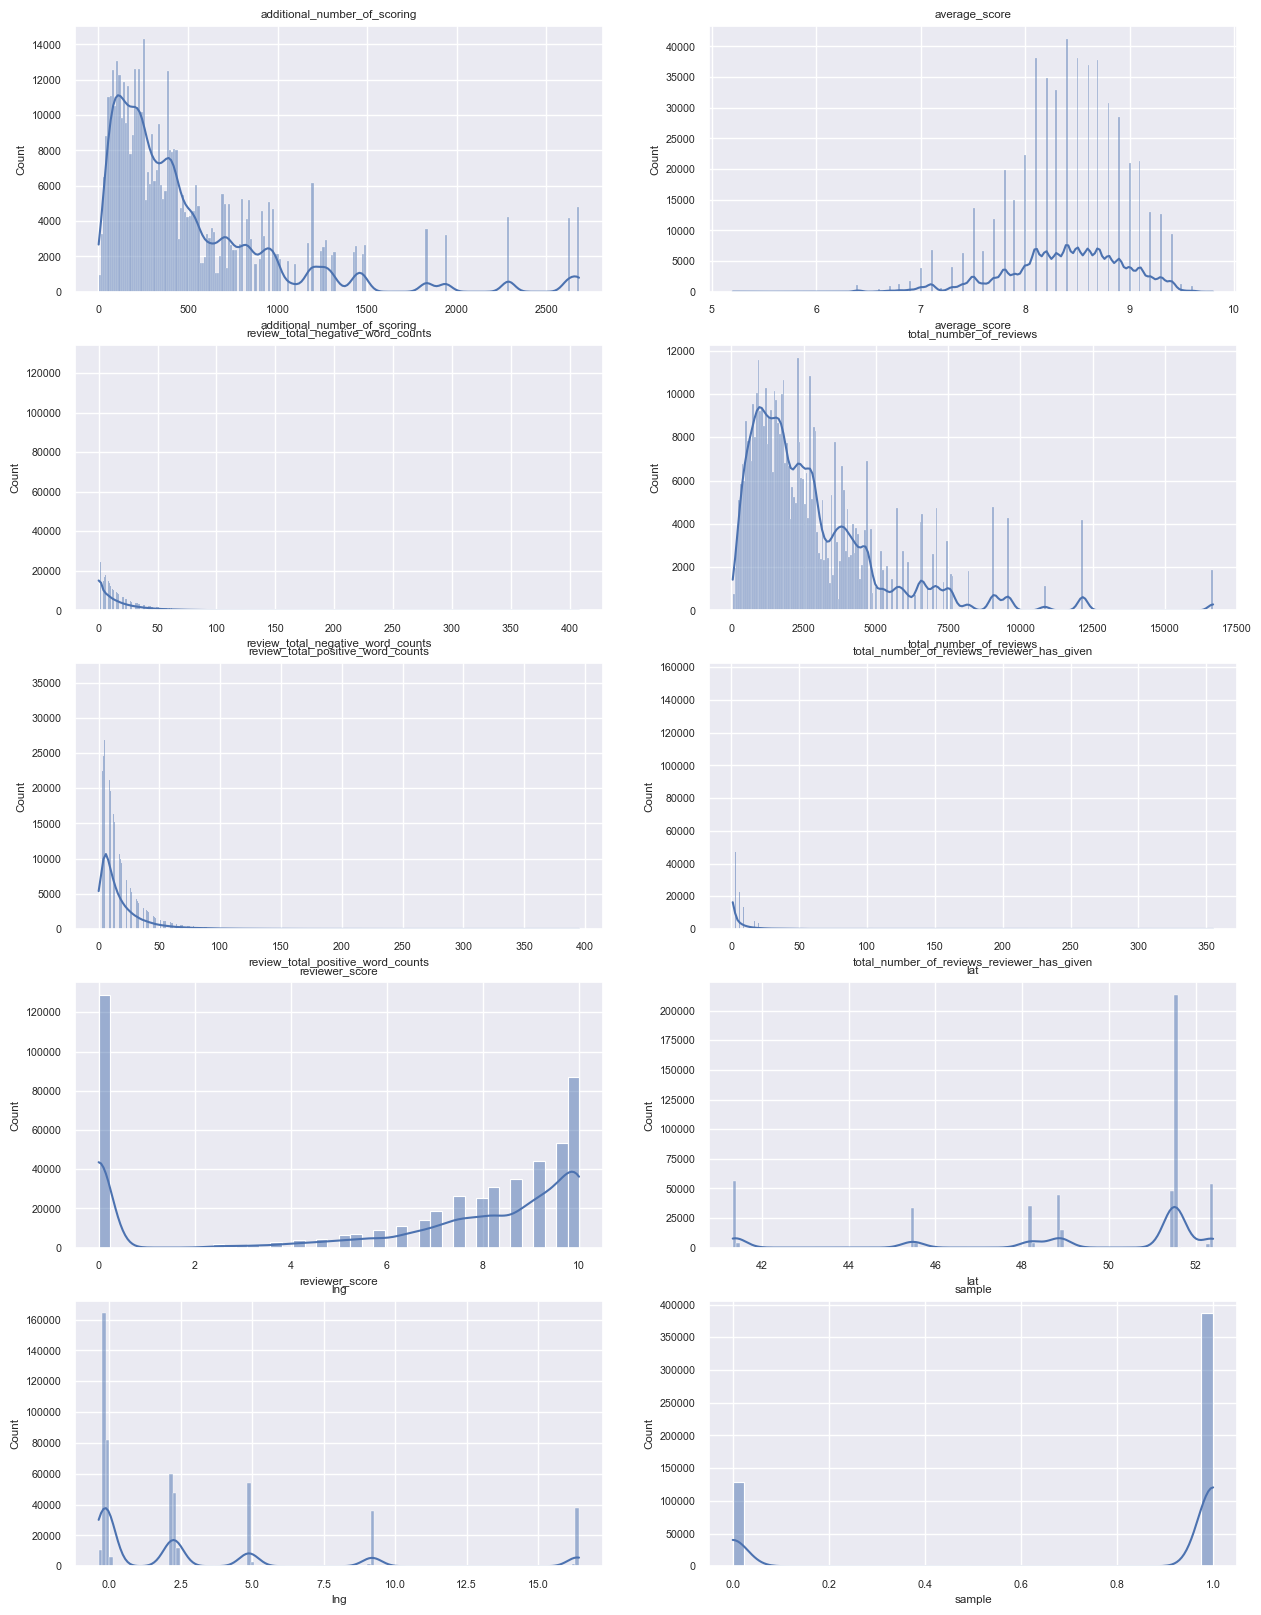

In [641]:
#Посмотрим распределение данных в числовых колонках кроме последней - там булевые значения, что мы сами сделали
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
j = 0
for i in range(5):
    for k in range(2):
        axes[i][k] = sns.histplot(data[num_columns[j]], kde=True, ax=axes[i][k])
        axes[i][k].set_title(num_columns[j])
        j += 1
plt.show()

### Пройдемся по всем признакам по порядк, оценим их содержимое и выдвинем гипотезы:



#### hotel_address - адрес отеля


In [642]:
data['hotel_address'].apply(lambda x: str(x.split()[-2:])).value_counts()

hotel_address
['United', 'Kingdom']           262300
['Barcelona', 'Spain']           60149
['Paris', 'France']              59626
['Amsterdam', 'Netherlands']     57212
['Vienna', 'Austria']            38938
['Milan', 'Italy']               37206
Name: count, dtype: int64


Признак уже изучили в рамках поиска геоданных, выделим страны, т.к. всего 6 стран и городов используется в адресе. Может быть посмотрим на индекс

#### additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.


In [643]:
# проверим как это выглядит на определеннм отеле:
data[data['hotel_name'] == 'Hotel Da Vinci']['additional_number_of_scoring']

653       904
1007      904
1213      904
1383      904
1870      904
         ... 
513784    904
514396    904
514472    904
514476    904
514792    904
Name: additional_number_of_scoring, Length: 1876, dtype: int64

видим, что оценки соотносятся с наименованием отеля и скорее всего, если мы закодируем наименование, то этот  признак будет не информативным, но в любом случае его проверим на связь с результатом

#### review_date - дата, когда рецензент разместил соответствующий отзыв.

In [644]:
# сразу же переведем признак в дату
data['review_date'] = pd.to_datetime(data['review_date']).dt.date

In [645]:
# проверим сеззоность оценок
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_quarter'] = pd.to_datetime(data['review_date']).dt.quarter

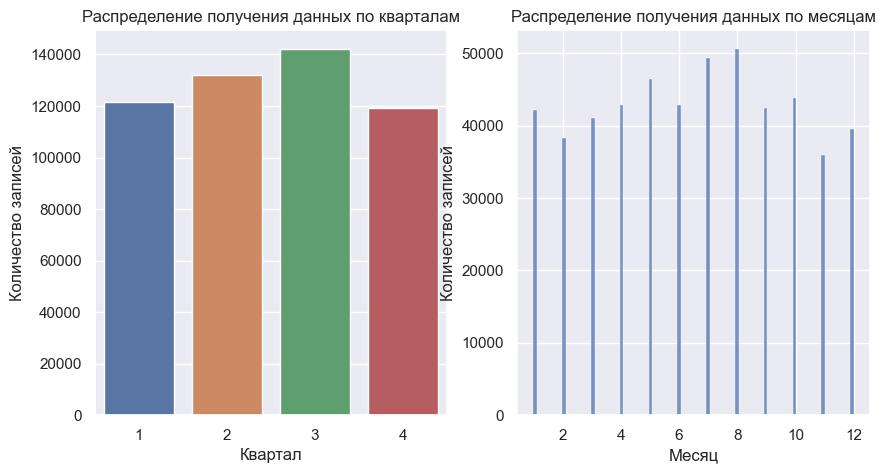

In [646]:
sns.set (font_scale= 1 )
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0] = sns.countplot(data, x='review_quarter', ax=axes[0])
axes[0].set(xlabel='Квартал', ylabel='Количество записей')
axes[0].set_title('Распределение получения данных по кварталам')


axes[1] = sns.histplot(data['review_month'], ax=axes[1])
axes[1].set(xlabel='Месяц', ylabel='Количество записей')
axes[1].set_title('Распределение получения данных по месяцам')


plt.show()

Предполагаю, что будет пощезно выделить в дальнейшем год оценки и месяц(возможно выделить сезон). Хотя судя по распределению, люди ставят оценки в разные периоды примерно одинаково. 

Стоит выделить признак выходных (отдых от бизнес- поездки скорее всего отличается по ожиданиям)

#### average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год

Этот признак также коррелируется с названием отеля, предварительно оставим его, возможно его усреднениие по оценкам за последний год окажет положительное влияние на предсказание

#### hotel_name - название отеля

In [647]:
data['hotel_name'].describe()

count                                         515431
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

In [648]:
data['hotel_name'][0].split()

['The', 'May', 'Fair', 'Hotel']

In [649]:
# получит ТОП-20 слов из названий отелей
hotel_name_dict = {}
for name in data['hotel_name']:
    for n in name.split():
        if n in hotel_name_dict.keys():
            hotel_name_dict[n] += 1
        else: hotel_name_dict[n] = 1
top_names = list(dict(sorted(hotel_name_dict.items(), reverse = True ,key=lambda item: item[1])).keys())[:20]

In [650]:
top_names

['Hotel',
 'London',
 'The',
 'Park',
 'Amsterdam',
 'Hilton',
 'by',
 'Plaza',
 'Paris',
 'Grand',
 'Inn',
 'Kensington',
 'Barcelona',
 'City',
 'Holiday',
 'DoubleTree',
 'Best',
 'Western',
 'tel',
 'H']

Предполагаю, что будеи полезным получить количество символов в названии отеля, в также наличие каких-то часто используемых слов.

#### reviewer_nationality - национальность рецензента

In [651]:
data['reviewer_nationality'].describe()

count               515431
unique                 227
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

Объем уникальных значений приерно приближен к количеству стран, предполагаю, что стоит как отдельно зашифровать саму национальность, так и провести сравнение со страной отеля, возможно повлияет на предсказание оценки (туристы с другиз стран возможно более впечатлсяются от отелей в ту или иную сторону, чем проживающие в той же стране и привыкшие к своему сервису)

#### negative_review - отрицательный отзыв, который рецензент дал отелю.

In [652]:
data['negative_review'].describe()

count          515431
unique         330011
top       No Negative
freq           127816
Name: negative_review, dtype: object

In [653]:
data['negative_review'][:5]

0               Leaving 
1         poor breakfast
2     No kettle in room 
3            No Negative
4           Torn sheets 
Name: negative_review, dtype: object

Видим, что может быть указано "No Negative", что будет означать отсутствие негативного отзыва, однако также стоит проверить на частые слова, вроде упоминания питания (завтрак/обед/ужин) или слово "комната"

#### review_total_negative_word_counts - общее количество слов в отрицательном отзыв

In [654]:
data['review_total_negative_word_counts'].describe()

count    515431.000000
mean         18.539760
std          29.690973
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

Возможно стоит разбить на группы по квантилям, чтобы определить уровенб негатива от посетителя

Из распределения выше видно, что большинство сконцентировано до 10 слов, что также подтверждает показатель - 50% 9.000000

#### total_number_of_reviews - общее количество действительных отзывов об отеле

In [655]:
data['total_number_of_reviews'].describe()

count    515431.000000
mean       2744.259084
std        2317.823718
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3633.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

Не исключено, что признак будлет полезен. Уверен будет правильным его распределить на части и подать как категориальный.

#### positive_review - положительный отзыв, который рецензент дал отелю

In [656]:
data['positive_review'].describe()

count          515431
unique         412601
top       No Positive
freq            35924
Name: positive_review, dtype: object

In [657]:
data['positive_review'][:5]

0                                   Staff were amazing
1                                             location
2                                          No Positive
3     Friendly staff quiet comfortable room spotles...
4     The staff was very friendly and helpful Break...
Name: positive_review, dtype: object

Признак противоположен negative_review, поступим с ним аналогично, выделим слова и какие-то значения, например время нахождения в отеле

#### total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом

In [658]:
data['total_number_of_reviews_reviewer_has_given'].describe()

count    515431.000000
mean          7.165215
std          11.038742
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

Скорее всего не сильно информативный признак, посмотрим его корреляцию с таргетом

#### tags - теги, которые рецензент дал отелю.

In [659]:
data['tags'].describe()

count                                                515431
unique                                                55242
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   5101
Name: tags, dtype: object

In [660]:
data['tags'][1]

"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']"

Предполагаю, что будет уместно получить из этих признаков вид поездки, количество гостей, вид аппартаментов и количество дней

#### days_since_review - продолжительность между датой проверки и датой очистки

In [661]:
data['days_since_review'].describe()

count     515431
unique       731
top       1 days
freq        2584
Name: days_since_review, dtype: object

Честно говоря не совсем понял этот признак, посмотрим как он повлияет на итоговый показатель

### lat - широта отеля, lng - долгота отеля


Предполагаю, что будет полезно разделить отели на климатические зоны, возможно они будут коррелировать с видом поездки (бизнес/отдых). Однако с оценкой вариантов госсударсв и городов 
Также возможно подумать над удалением отеля от центра города

<a id='4'></a>


## 4. Генерация признаков

<a href ="#0"> Вверх</a>

In [662]:
# Выберем интересное из адреса отеля, например страну:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))

In [663]:
# к кварталу и месяцу добавим отдельно год:
data['review_year'] = pd.to_datetime(data['review_date']).dt.year

In [664]:
# добавим длину названия отеля и отдельно выделим есть ли ТОП-слово в названии отеля
data['hotel_name_len'] = data['hotel_name'].apply(lambda x: len(x))

#for name in data['hotel_name']:
#    for word in top_names:
#        data['name_' + word] = 1 if word in name else 0
# Отказался от этой идеи т.к. слишкоим долгое вычисление

In [665]:
# добавим признак отсутствия негативного суждения об отеле
data['no_negative'] = data['negative_review'].apply(lambda x: 1 if 'No Negative' in x else 0 )

In [666]:
# добавим признак отсутствия позитивного отзыва об отеле
data['no_positive'] = data['positive_review'].apply(lambda x: 1 if 'No Positive' in x else 0 )

In [667]:
# добавим признак количество ночей в отеле

data['tags'] = data['tags'].apply(lambda x: x.replace("[' ", "").replace(" ']", "").split(" ', ' "))

def get_night(arg):
    #описания таким функциям добавлять не буду, т.к. они одноразовые
    for tag in arg:
        if 'Stayed' in tag:
            return int(tag.split()[1])
        
data['nights'] = data['tags'].apply(get_night)



In [668]:
print(f'количество пропусков в новом признаке до:{data[data.nights.isna()].shape[0]}')

#заменим значение медианой
data['nights'] = data['nights'].fillna(data.nights.median())
print(f'количество пропусков в новом признаке после:{data[data.nights.isna()].shape[0]}')

количество пропусков в новом признаке до:192
количество пропусков в новом признаке после:0


In [669]:
#добавим признак - вид поездки

def get_trip(arg):
    for tag in arg:
        if 'trip' in tag:
            return tag.split()[0]
        
data['trip_type'] = data['tags'].apply(get_trip)

In [670]:
print(f'количество пропусков в новом признаке до:{data[data.trip_type.isna()].shape[0]}')

#заменим значение модой
data['trip_type'] = data['trip_type'].fillna('Leisure')
print(f'количество пропусков в новом признаке после:{data[data.trip_type.isna()].shape[0]}')

количество пропусков в новом признаке до:15009
количество пропусков в новом признаке после:0


Рассчитаем расстояние между центром города и отелем

In [671]:
!pip install geopy 
from geopy.distance import geodesic as GD 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: C:\Program Files\Python311\python.exe -m pip install --upgrade pip


In [672]:
# Добавим координаты городов, сразу применимо к колонке hotel_country:

coordinates = {
    'United Kingdom' : (51.50741654122609, -0.12763493006143845),
    'Spain' : (41.382778, 2.176944),
    'France' : (48.856667, 2.352222),
    'Netherlands' : (52.372778, 4.893611),
    'Austria' : (48.208333, 16.3725),
    'Italy': (45.466944, 9.19)
}

In [673]:
# новый признак будет указывать на расстояние от отеля до центра города
data['hotel_distance'] = data.apply(lambda x: GD( (x.lat, x.lng), coordinates[x.hotel_country]).km, axis = 1)

In [674]:
data['hotel_distance'][:5]

0    1.114614
1    1.544684
2    2.319755
3    4.724911
4    3.476300
Name: hotel_distance, dtype: float64

<style>
  p {
  font-family: Verdana, Arial, Helvetica, sans-serif; 
  font-size: 13pt; /* Размер шрифта в пунктах */ 
  }
</style>
<span style="color:green"><b>Вывод:</b></span> <br>
В ходе работы мы сделали несколько новых признаков и наш датафрейм увеличился в размерах.

У появились новые признаки:
* hotel_distance - расстояние от оттеля до центра города
* trip_type - вид поездки (бизнес/частная)
* nights - количество ночей в отеле
* no_negative / no_positive - признаки-индикаторы, показывающиее отсутствие позитивного или негативного отзывов
* hotel_country - страна, где находится отель
* hotel_name_len - длинна названия отеля
* review_year / month / quarter - год, месяц, квартал оценки

<a id='5'></a>


## 5. Преобразование признаков

<a href ="#0"> Вверх</a>

Закодируем категориальные признаки через OrdinalEncoder() т.к. используем случайный лес

In [675]:
cols_df = [x for x in data.columns if data[x].dtype == 'object']

In [676]:
# посмотрим внимательнее на список получившихся признаков, затем уберем не нужное
cols_df

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_country',
 'trip_type']

'hotel_address', - лишний, у нас есть место

 'review_date', - лишний, дата разложена на составляющие

 'hotel_name', - уже преобразован в размер

 'reviewer_nationality', - необходимо закодировать

 'negative_review', - лишний, преобразован в булевое значение

 'positive_review', - лишний, преобразован в булевое значение

 'tags', -  лишний, преобразован в несколько других значений

 'days_since_review', - оставим только число

 'hotel_country', - необходимо закодировать

 'trip_type' - необходимо закодировать

In [677]:
# признак числовой, уберем лишнее
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

In [679]:
#Добавим оценку комментариев
sent_analyzer = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(sent_analyzer.polarity_scores)
data['pos_scores'] = data['positive_review'].apply(sent_analyzer.polarity_scores)

data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

In [680]:
import category_encoders as ce

cols_df_cod = ['reviewer_nationality',  'hotel_country', 'trip_type']

ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data[cols_df_cod])

In [681]:
cols_df = [x for x in data.columns if data[x].dtype != 'object']

In [682]:
data_fr = data[cols_df]
data_cod = pd.concat([data_fr, data_bin], axis=1)

<a id='6'></a>


## 6. Отбор признаков

<a href ="#0"> Вверх</a>

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

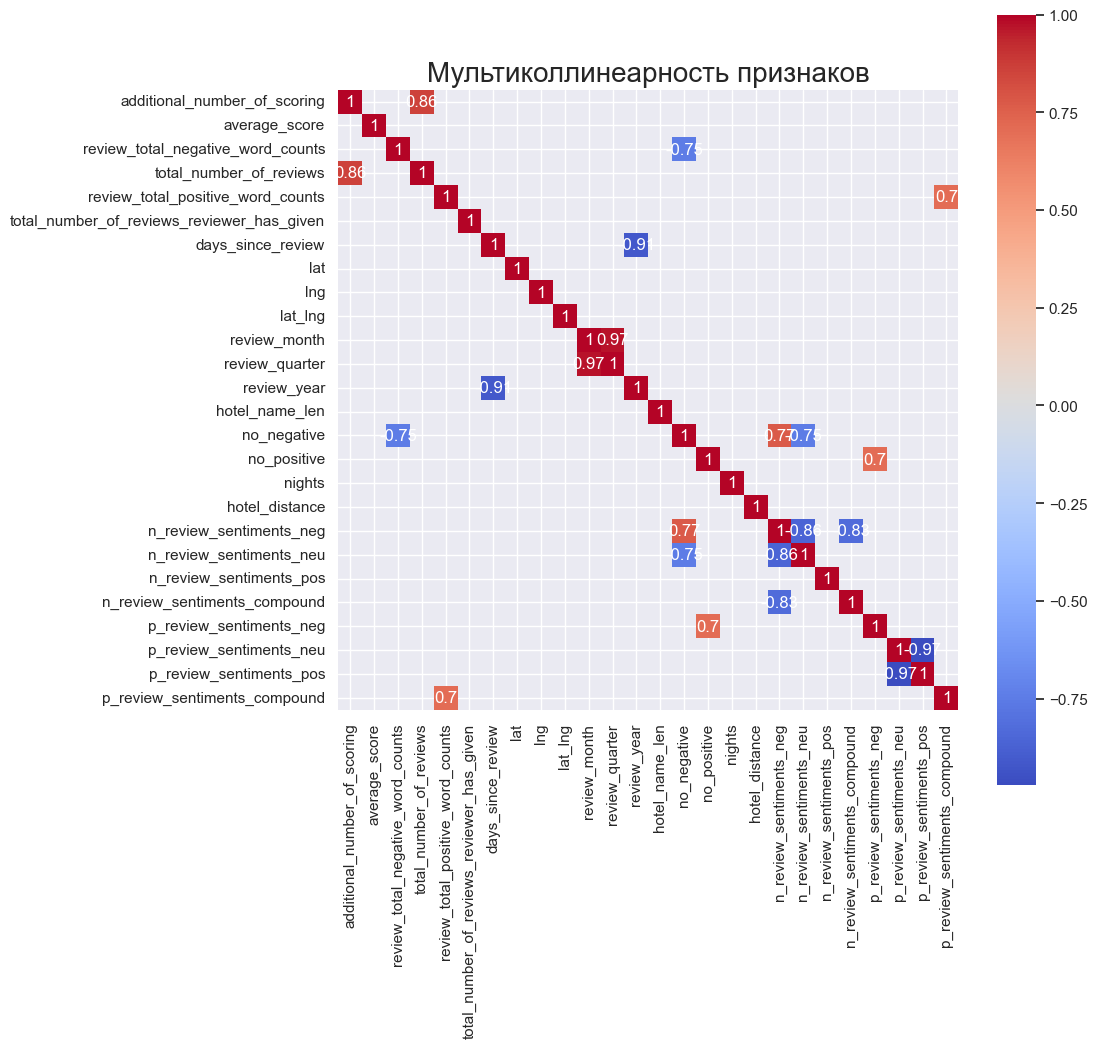

In [683]:
# посмотрим корреляционную матрицу и анализируем данные на предмет мультиколлинеарности
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr( numeric_only = True, method='spearman')
plt.subplots(figsize=(10, 10))

# выведем только сильную
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7],         cmap='coolwarm',     square=True,
    annot = True
)


ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Проверил много раз с удалением разных признаков, score улучшается только при удалении **additional_number_of_scoring**

In [684]:
data_cod.drop('additional_number_of_scoring', axis = 1, inplace=True)

In [685]:
RANDOM_SEED = 42

In [686]:
# Для начала разделим признаки по типу, перечислим их:

# непрерывные признаки
num_cols = ['average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'hotel_name_len', 'hotel_distance']

# категориальные признаки
cat_cols = ['reviewer_nationality',  'hotel_country', 'trip_type', 'nights', 'no_positive', 'no_negative', 'review_quarter', 'review_month', 'lat_lng']

In [687]:
train_data = data_cod.query('sample == 1').drop(['sample'], axis=1)
test_data = data_cod.query('sample == 0').drop(['sample'], axis=1)

In [688]:
# Теперь выделим тестовую часть
y = train_data.reviewer_score.values       
X = train_data.drop(['reviewer_score'], axis=1)

<Axes: >

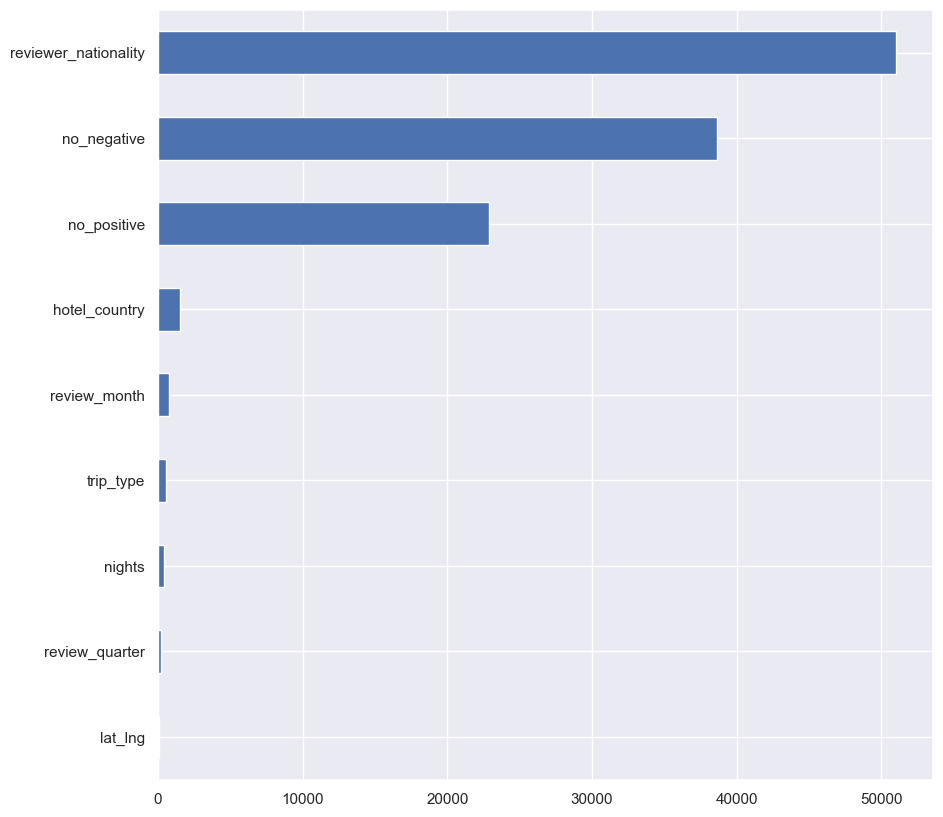

In [689]:
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y.astype('int'))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

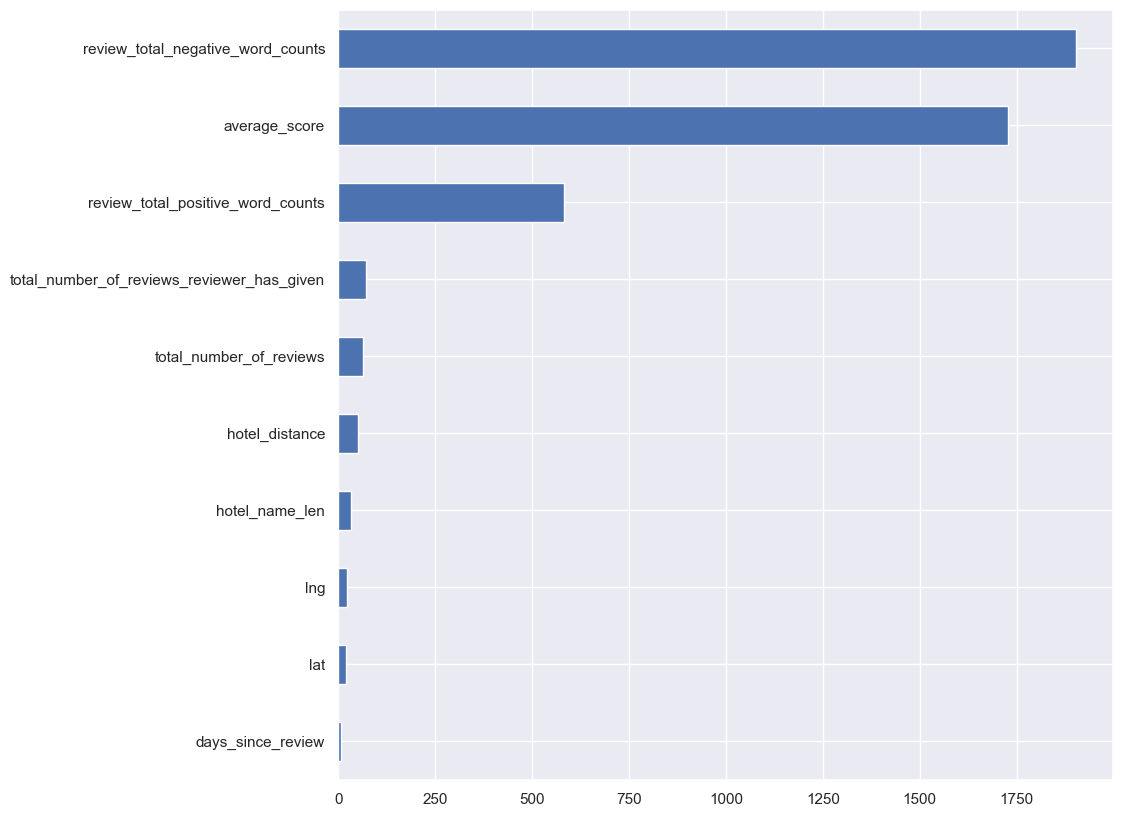

In [690]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<a id='7'></a>


## 7. Обучение модели

<a href ="#0"> Вверх</a>

In [691]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [692]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 29), (386496, 29), (386496, 28), (309196, 28), (77300, 28))

In [693]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [694]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [695]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [696]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8743514749892193


<Axes: >

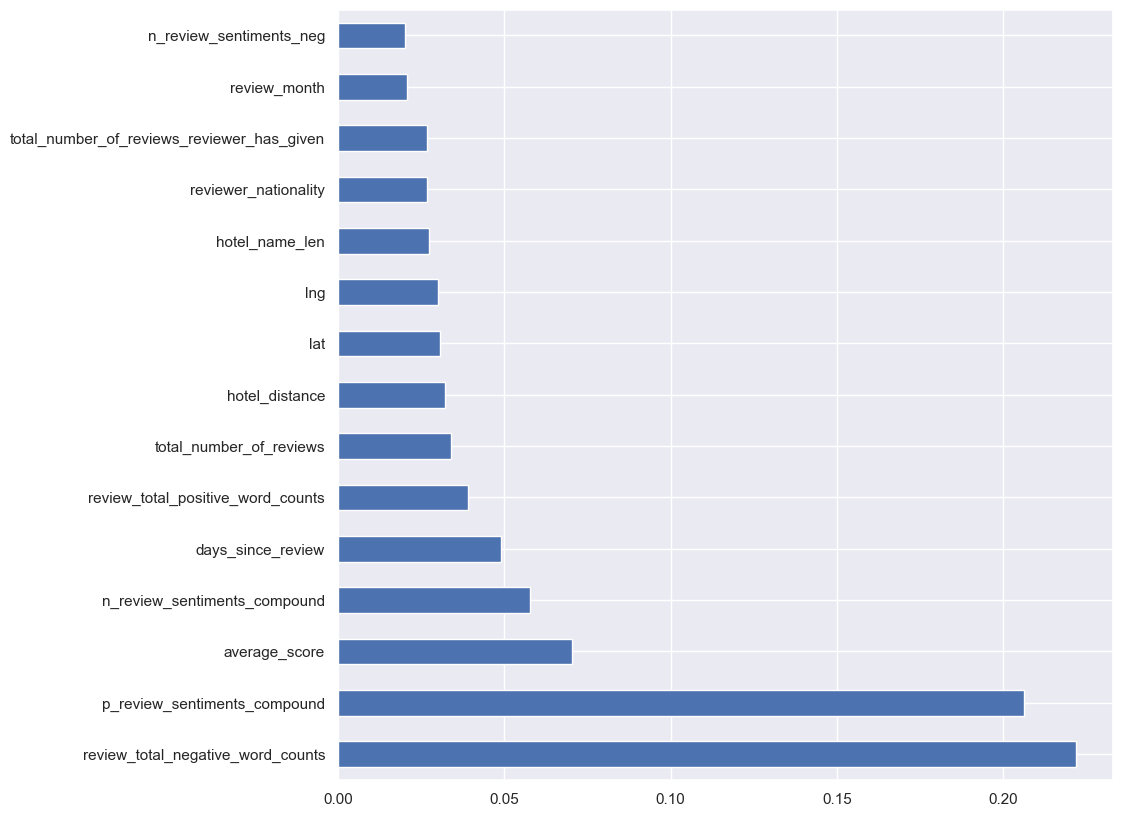

In [697]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [698]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,lat_lng,...,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,reviewer_nationality,hotel_country,trip_type
454023,8.5,9,5177,16,2,0.0,659,48.214662,16.362799,False,...,0.463,0.537,0.7880,0.211,0.278,0.510,0.8226,12,5,1
458103,7.5,15,3811,7,4,0.0,543,45.499520,9.206138,False,...,0.613,0.000,-0.8218,0.000,0.389,0.611,0.7425,58,4,1
497708,8.1,0,544,17,1,0.0,579,48.834681,2.325510,False,...,0.000,0.000,-0.7096,0.000,0.518,0.482,0.9201,12,2,1
475323,8.5,51,4032,16,3,0.0,150,52.363889,4.881302,False,...,0.869,0.048,-0.2006,0.000,0.506,0.494,0.8945,36,3,1
461904,8.2,0,1969,10,10,0.0,438,45.476992,9.184490,False,...,0.000,0.000,-0.7096,0.000,0.370,0.630,0.8807,39,4,1
445818,9.0,0,1254,11,2,0.0,263,51.517167,-0.129053,False,...,0.000,0.000,-0.7096,0.000,0.490,0.510,0.8070,1,1,1
485394,8.6,0,1641,10,2,0.0,113,51.517608,-0.127625,False,...,0.000,0.000,-0.7096,0.000,0.694,0.306,0.4754,1,1,1
486611,7.9,17,4065,4,2,0.0,550,51.516288,-0.172108,False,...,0.656,0.159,-0.1263,0.000,1.000,0.000,0.0000,5,1,1
399781,8.5,19,6596,7,31,0.0,576,51.512974,-0.183743,False,...,1.000,0.000,0.0000,0.000,0.328,0.672,0.7297,1,1,2
459423,8.7,6,7491,11,1,0.0,313,51.510841,-0.078058,False,...,0.278,0.292,-0.2500,0.000,0.408,0.592,0.8271,1,1,1


In [699]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [700]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [701]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


In [702]:
predict_submission

array([8.657, 6.966, 8.355, ..., 8.053, 9.483, 6.887])

In [703]:
list(sample_submission)

['reviewer_score', 'id']

In [704]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.657,488440
1,6.966,274649
2,8.355,374688
3,9.701,404352
4,9.534,451596
5,8.758,302161
6,7.697,317079
7,7.948,13963
8,8.612,159785
9,7.267,195089
